In [14]:
from skimage.measure import shannon_entropy
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2 as cv
import random

In [8]:
X_train = np.load("X_train.npy")
Y_train = np.load("Y_train.npy", allow_pickle=True)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("Unique labels:", np.unique(Y_train))


X_train shape: (5712, 128, 128, 1)
Y_train shape: (5712,)
Unique labels: ['glioma' 'meningioma' 'notumor' 'pituitary']


In [10]:
def compute_features(img):
    img_2d = img.squeeze()

    mean = np.mean(img_2d)
    std = np.std(img_2d)
    entropy = shannon_entropy(img_2d)

    mid = img_2d.shape[1] // 2
    left = img_2d[:, :mid]
    right = np.fliplr(img_2d[:, mid:])
    symmetry = np.mean(np.abs(left - right))

    return [mean, std, entropy, symmetry]

# Compute features for all images
features = [compute_features(img) for img in X_train]

# Create DataFrame
df_features = pd.DataFrame(features, columns=["Mean", "StdDev", "Entropy", "Symmetry"])
df_features["Label"] = Y_train


In [11]:
print(df_features.head())
print(df_features.groupby("Label").mean())


       Mean    StdDev   Entropy  Symmetry      Label
0  0.213585  0.171467  6.672078  0.056235  pituitary
1  0.145055  0.131316  6.424951  0.105532  pituitary
2  0.176062  0.170265  5.765955  0.048919  pituitary
3  0.241285  0.162809  6.816878  0.051151  pituitary
4  0.146622  0.176547  5.619110  0.073104  pituitary
                Mean    StdDev   Entropy  Symmetry
Label                                             
glioma      0.128618  0.149537  5.310935  0.058880
meningioma  0.167534  0.182679  5.759720  0.080355
notumor     0.213044  0.230417  5.552487  0.086764
pituitary   0.193567  0.161049  6.358980  0.085959


HOG

In [12]:
from skimage.feature import hog
from skimage import exposure

# Sample HOG setup (you can tune these)
hog_params = {
    "orientations": 9,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "block_norm": 'L2-Hys'
}

# Compute HOG features for each image
hog_features = []

for img in X_train:
    img_2d = img.squeeze()  # shape: (128, 128)
    features = hog(img_2d, **hog_params)
    hog_features.append(features)

hog_features = np.array(hog_features)
print("HOG feature shape:", hog_features.shape)


HOG feature shape: (5712, 8100)


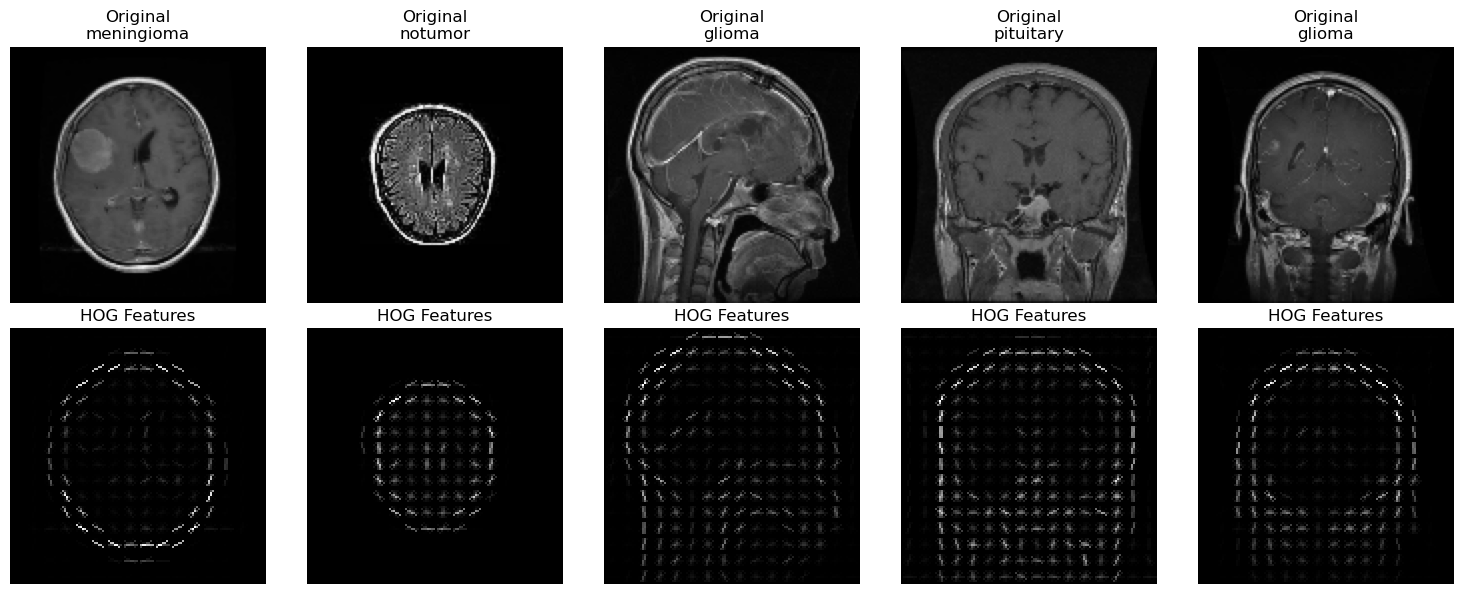

In [16]:
from skimage.feature import hog

# HOG parameters
hog_params = {
    "orientations": 9,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "block_norm": 'L2-Hys',
    "visualize": True
}

# Randomly pick 5 images
sample_indices = random.sample(range(len(X_train)), 5)

plt.figure(figsize=(15, 6))

for i, idx in enumerate(sample_indices):
    img = X_train[idx].squeeze()

    fd, hog_image = hog(img, **hog_params)

    # Original image
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{Y_train[idx]}")
    plt.axis('off')

    # HOG visualization
    plt.subplot(2, 5, i + 6)
    plt.imshow(hog_image, cmap='gray')
    plt.title("HOG Features")
    plt.axis('off')

plt.tight_layout()
plt.show()


PIXEL BRIGHTNESS

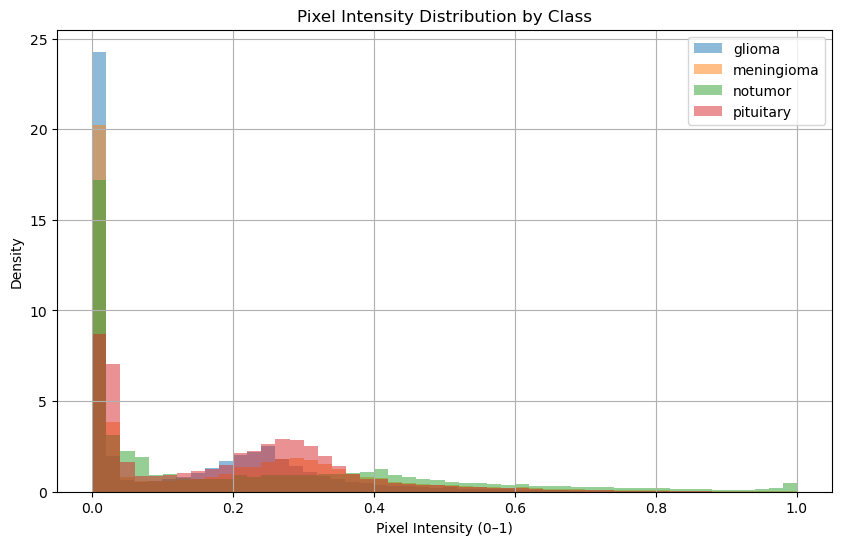

In [ ]:
plt.figure(figsize=(10, 6))

unique_labels = np.unique(Y_train)
for label in unique_labels:
    imgs = X_train[Y_train == label]  
    pixels = imgs.flatten()
    plt.hist(pixels, bins=50, alpha=0.5, label=label, density=True)

plt.title("Pixel Intensity Distribution by Class")
plt.xlabel("Pixel Intensity (0–1)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


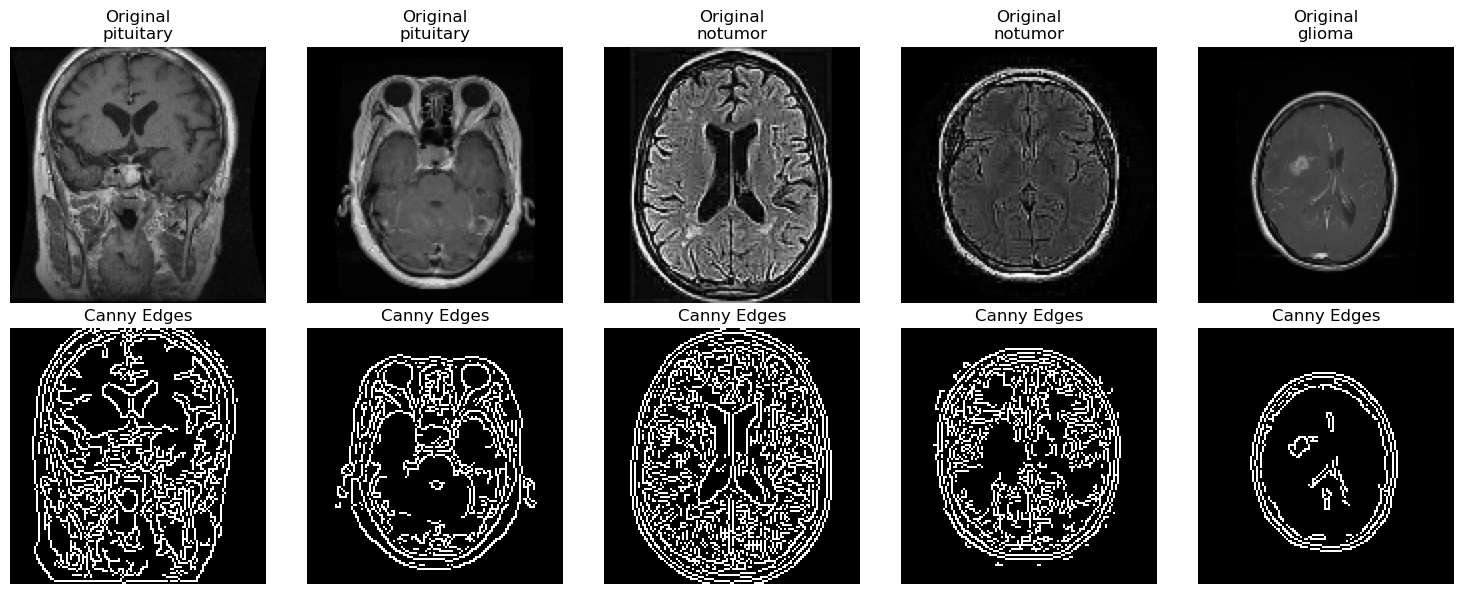

In [19]:
import cv2


# Select 5 random images
sample_indices = random.sample(range(len(X_train)), 5)

plt.figure(figsize=(15, 6))

for i, idx in enumerate(sample_indices):
    img = (X_train[idx].squeeze() * 255).astype(np.uint8)  # convert to uint8 [0-255]

    # Apply Canny edge detection
    edges = cv2.Canny(img, threshold1=50, threshold2=150)

    # Plot original and edges
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{Y_train[idx]}")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(edges, cmap='gray')
    plt.title("Canny Edges")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [20]:
# Create new array with 2 channels: grayscale + canny
X_train_combined = []

for img in X_train:
    img_gray = img.squeeze()
    
    # Convert to uint8 and apply Canny
    img_uint8 = (img_gray * 255).astype(np.uint8)
    edges = cv2.Canny(img_uint8, threshold1=50, threshold2=150)

    # Normalize Canny to 0–1 and stack with original
    edges_norm = edges / 255.0
    stacked = np.stack([img_gray, edges_norm], axis=-1)  # shape: (128, 128, 2)

    X_train_combined.append(stacked)

X_train_combined = np.array(X_train_combined)

print("Original X_train shape:", X_train.shape)
print("New X_train_combined shape:", X_train_combined.shape)


Original X_train shape: (5712, 128, 128, 1)
New X_train_combined shape: (5712, 128, 128, 2)


In [23]:
def compute_horizontal_symmetry(img):
    img = img.squeeze()
    mid = img.shape[1] // 2
    left = img[:, :mid]
    right = np.fliplr(img[:, mid:])
    # Crop to same shape if image width is odd
    min_w = min(left.shape[1], right.shape[1])
    return np.mean(np.abs(left[:, :min_w] - right[:, :min_w]))
from scipy.ndimage import center_of_mass

def compute_center_of_mass(img):
    img = img.squeeze()
    com = center_of_mass(img)
    return com  # (y, x) position in the image
symmetry_scores = []
com_y = []
com_x = []

for img in X_train:
    symmetry = compute_horizontal_symmetry(img)
    com = compute_center_of_mass(img)
    symmetry_scores.append(symmetry)
    com_y.append(com[0])
    com_x.append(com[1])


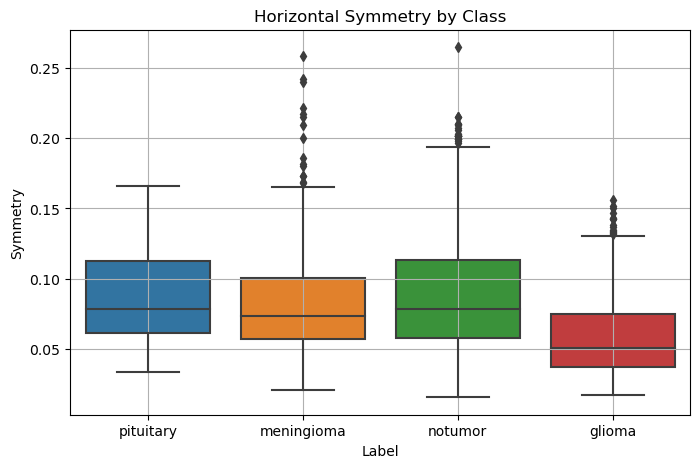

In [25]:
import seaborn as sns

df_sym = pd.DataFrame({
    "Label": Y_train,
    "Symmetry": symmetry_scores
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_sym, x="Label", y="Symmetry")
plt.title("Horizontal Symmetry by Class")
plt.grid(True)
plt.show()


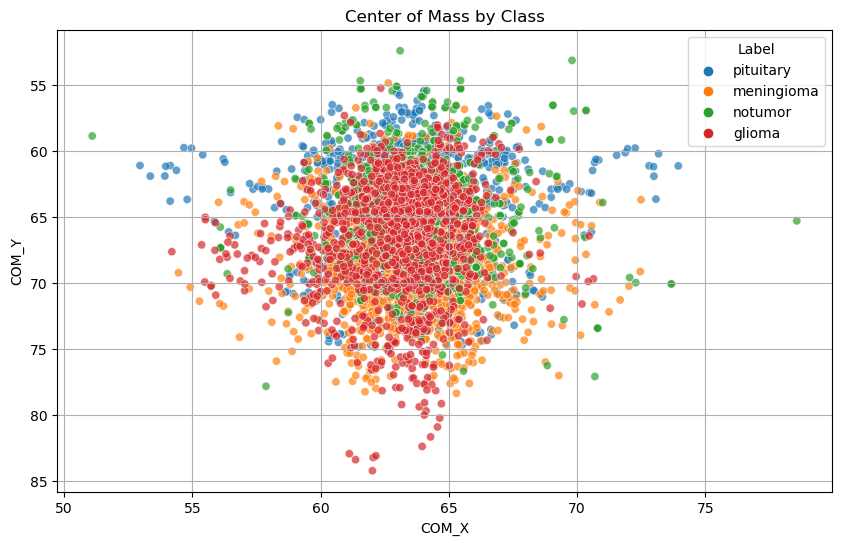

In [26]:
df_com = pd.DataFrame({
    "Label": Y_train,
    "COM_Y": com_y,
    "COM_X": com_x
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_com, x="COM_X", y="COM_Y", hue="Label", alpha=0.7)
plt.title("Center of Mass by Class")
plt.gca().invert_yaxis()  # flip Y-axis to match image space
plt.grid(True)
plt.show()


In [ ]:
X_train_augmented = []

for i in range(len(X_train_combined)):
    grayscale = X_train_combined[i][:,:,0]
    edges = X_train_combined[i][:,:,1]

    # Create constant maps with symmetry and COM
    symmetry_map = np.full_like(grayscale, symmetry_scores[i])
    comx_map = np.full_like(grayscale, com_x[i] / 128)  # normalize
    comy_map = np.full_like(grayscale, com_y[i] / 128)

    # Stack all 
    stacked = np.stack([grayscale, edges, symmetry_map], axis=-1)
    X_train_augmented.append(stacked)

X_train_augmented = np.array(X_train_augmented)
print("New shape:", X_train_augmented.shape)  


New shape: (5712, 128, 128, 3)


FOURIER TRANSFORM

In [28]:
def extract_fourier_features(img):
    img = img.squeeze()
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude = np.abs(fshift)

    # Summary features:
    mean_freq = np.mean(magnitude)
    max_freq = np.max(magnitude)
    std_freq = np.std(magnitude)
    
    # High vs. low frequency energy
    h, w = magnitude.shape
    center = magnitude[h//4:3*h//4, w//4:3*w//4]
    low_freq_energy = np.sum(center)
    high_freq_energy = np.sum(magnitude) - low_freq_energy
    high_low_ratio = high_freq_energy / (low_freq_energy + 1e-8)
    
    return [mean_freq, std_freq, max_freq, high_low_ratio]


In [29]:
fourier_features = [extract_fourier_features(img) for img in X_train]

df_fourier = pd.DataFrame(fourier_features, columns=[
    "FFT_Mean", "FFT_Std", "FFT_Max", "FFT_HighLowRatio"
])
df_fourier["Label"] = Y_train


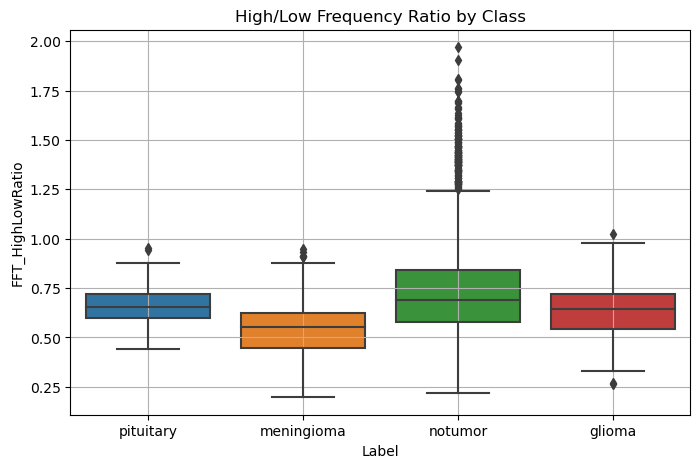

In [30]:

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_fourier, x="Label", y="FFT_HighLowRatio")
plt.title("High/Low Frequency Ratio by Class")
plt.grid(True)
plt.show()


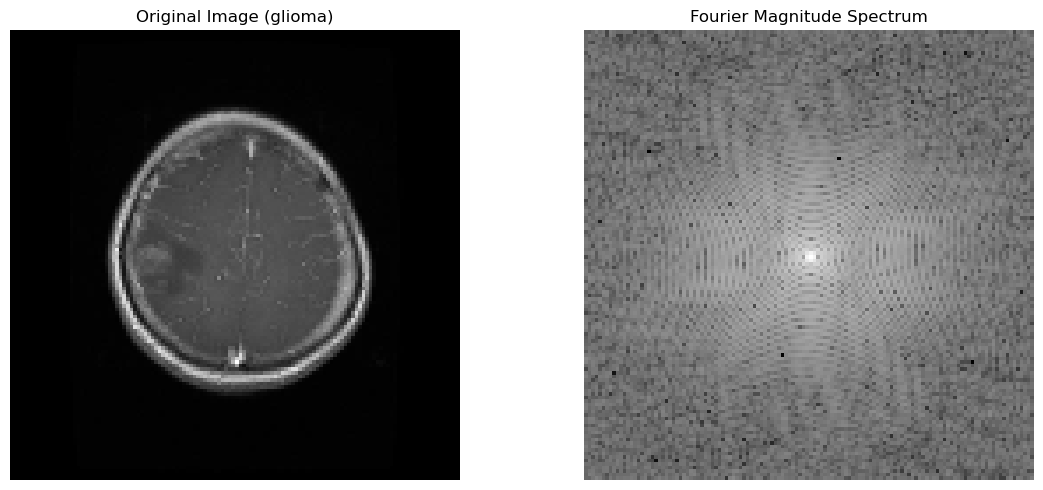

In [31]:
idx = random.randint(0, len(X_train) - 1)
img = X_train[idx].squeeze()
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
spectrum = 20 * np.log(np.abs(fshift) + 1e-8)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title(f"Original Image ({Y_train[idx]})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spectrum, cmap='gray')
plt.title("Fourier Magnitude Spectrum")
plt.axis('off')
plt.tight_layout()
plt.show()
